# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [3]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


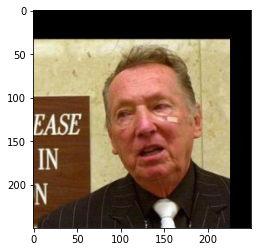

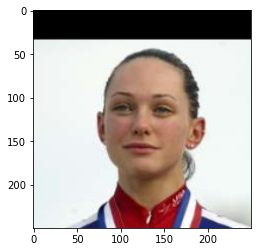

In [6]:
#View the sample human photos.
import random
from PIL import Image
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

for img in random.sample(list(human_files), 2): 
#open and display input image
    image = Image.open(img) #img_path
    plt.imshow(image)
    plt.show()

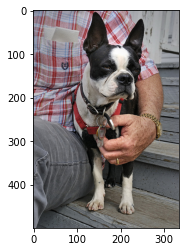

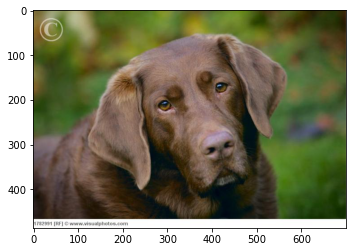

In [55]:
#View the sample dog photos.
for img in random.sample(list(dog_files), 2): 
#open and display input image
    image = Image.open(img) #img_path
    plt.imshow(image)
    plt.show()

In [71]:
def filtered_images(image_path):
    mono_images=[]
    non_mono_images=[]
    for filename in image_path:
        try:
            img=Image.open(filename)
            #check pixel distribution
            v=img.histogram()
            h,w=img.size
            percentage_monochrome=max(v)/float(h*w)
            # filter bad and small images
            if percentage_monochrome>0.5 :#or h<300 or w<300:
                mono_images.append(filename)
            else:
                non_mono_images.append(filename)
        except:
            pass
    print("Number of monochrome images: {}\n".format(len(mono_images)))
    print("Number of non-monochrome images: {}\n".format(len(non_mono_images)))
    return mono_images, non_mono_images

In [72]:
filtered_images(dog_files)

Number of monochrome images: 85

Number of non-monochrome images: 8265



(['dogImages\\test\\004.Akita\\Akita_00270.jpg',
  'dogImages\\test\\015.Basset_hound\\Basset_hound_01071.jpg',
  'dogImages\\test\\027.Bloodhound\\Bloodhound_01912.jpg',
  'dogImages\\test\\056.Dachshund\\Dachshund_03967.jpg',
  'dogImages\\test\\092.Keeshond\\Keeshond_06280.jpg',
  'dogImages\\train\\002.Afghan_hound\\Afghan_hound_00123.jpg',
  'dogImages\\train\\003.Airedale_terrier\\Airedale_terrier_00161.jpg',
  'dogImages\\train\\004.Akita\\Akita_00250.jpg',
  'dogImages\\train\\004.Akita\\Akita_00255.jpg',
  'dogImages\\train\\004.Akita\\Akita_00271.jpg',
  'dogImages\\train\\005.Alaskan_malamute\\Alaskan_malamute_00316.jpg',
  'dogImages\\train\\005.Alaskan_malamute\\Alaskan_malamute_00321.jpg',
  'dogImages\\train\\008.American_staffordshire_terrier\\American_staffordshire_terrier_00574.jpg',
  'dogImages\\train\\008.American_staffordshire_terrier\\American_staffordshire_terrier_00584.jpg',
  'dogImages\\train\\008.American_staffordshire_terrier\\American_staffordshire_terrier

# Create image frequency distribution for each dog class

In [178]:
import os
entries = os.listdir('dogImages/train')
entries

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog',
 '011.Australian_cattle_dog',
 '012.Australian_shepherd',
 '013.Australian_terrier',
 '014.Basenji',
 '015.Basset_hound',
 '016.Beagle',
 '017.Bearded_collie',
 '018.Beauceron',
 '019.Bedlington_terrier',
 '020.Belgian_malinois',
 '021.Belgian_sheepdog',
 '022.Belgian_tervuren',
 '023.Bernese_mountain_dog',
 '024.Bichon_frise',
 '025.Black_and_tan_coonhound',
 '026.Black_russian_terrier',
 '027.Bloodhound',
 '028.Bluetick_coonhound',
 '029.Border_collie',
 '030.Border_terrier',
 '031.Borzoi',
 '032.Boston_terrier',
 '033.Bouvier_des_flandres',
 '034.Boxer',
 '035.Boykin_spaniel',
 '036.Briard',
 '037.Brittany',
 '038.Brussels_griffon',
 '039.Bull_terrier',
 '040.Bulldog',
 '041.Bullmastiff',
 '042.Cairn_terrier',
 '043.Canaan_do

In [188]:
print (len([name for name in os.listdir('dogImages/train') if os.path.isfile(name)]))

0


In [198]:
import pathlib
count = 0
for path in pathlib.Path("dogImages/train").iterdir():
    if path.is_file():
        count += 1

print(count)

0


In [145]:
import fnmatch
freq=[]
for file_name in os.listdir('dogImages'):
    if fnmatch.fnmatch(file_name, "\\*\\"+entries+"\\*.*"):

        

TypeError: can only concatenate str (not "list") to str

In [125]:
import pandas as pd
import numpy as np
dog_files.shape
type(dog_files)

df=pd.DataFrame(data=dog_files)
df.shape


(8351, 1)

In [173]:
array.split('\\')[2]

AttributeError: 'numpy.ndarray' object has no attribute 'split'

In [147]:
df.head()

0  \
0  dogImages\test\001.Affenpinscher\Affenpinscher...   
1  dogImages\test\001.Affenpinscher\Affenpinscher...   
2  dogImages\test\001.Affenpinscher\Affenpinscher...   
3  dogImages\test\001.Affenpinscher\Affenpinscher...   
4  dogImages\test\001.Affenpinscher\Affenpinscher...   

                                           dog_breed  
0  dogImages\test\001.Affenpinscher\Affenpinscher...  
1  dogImages\test\001.Affenpinscher\Affenpinscher...  
2  dogImages\test\001.Affenpinscher\Affenpinscher...  
3  dogImages\test\001.Affenpinscher\Affenpinscher...  
4  dogImages\test\001.Affenpinscher\Affenpinscher...

In [165]:
df['dog_breed']


0       dogImages\test\001.Affenpinscher\Affenpinscher...
1       dogImages\test\001.Affenpinscher\Affenpinscher...
2       dogImages\test\001.Affenpinscher\Affenpinscher...
3       dogImages\test\001.Affenpinscher\Affenpinscher...
4       dogImages\test\001.Affenpinscher\Affenpinscher...
                              ...                        
8346    dogImages\valid\132.Xoloitzcuintli\Xoloitzcuin...
8347    dogImages\valid\133.Yorkshire_terrier\Yorkshir...
8348    dogImages\valid\133.Yorkshire_terrier\Yorkshir...
8349    dogImages\valid\133.Yorkshire_terrier\Yorkshir...
8350    dogImages\valid\133.Yorkshire_terrier\Yorkshir...
Name: dog_breed, Length: 8351, dtype: object

In [168]:
df['dog_breed']=df['dog_breed'].split(' ')[2]
#dog_breaks.head()
#df2=pd.DataFrame(data=dog_breaks)
#df2.head()
dog_breaks

AttributeError: 'Series' object has no attribute 'split'

In [182]:
fullstring = df[0]
substring = entries

if substring in fullstring:
    print ("Found!")
else:
    print ("Not found!")

TypeError: unhashable type: 'list'

In [132]:
df.columns.values

array([0], dtype=int64)

In [146]:
df['dog_breed']= df[0]

In [ ]:
for entries in dogImages:
    count

In [139]:
n_by_state = df.groupby(entries).count()
n_by_state.head(10)

KeyError: '001.Affenpinscher'

In [76]:
#the address where the program will look into.
# create loop for each of the classes
#identify the number of classes
#create a bar chart based on number of images. 
#loop through all the class to count all the files in each class
for file in dog_files:
    
    if file==dogImages\*\*.*\:
        print(file)
    
#sum the number of images in each classes for dogs and humans. 
#if dog or human detected



SyntaxError: unexpected character after line continuation character (<ipython-input-76-9189dedaaec2>, line 8)

In [ ]:
#if dog or human detected
    my_list=[]
    #predictedimage=datatrain.classes(raw_class)
    raw_class=predict_breed_transfer(img_path)
    for classes in dogImages:
        
        pred_dir="dogImages/*/"+"/"+entries+"/*.*"

#    class_names =raw_class.replace("_"," ")[4:]

    #prepare random sample data from the predicted breed
    predpath=glob.glob(pred_dir)
    for file in random.sample(list(predpath),1):
      #  print(file)
        a=Image.open(file)
        my_list.append(a)
        


In [68]:
#def filtered_images(image_path):
h=[]
w=[]
for filename in dog_files[:100]:
    img=Image.open(filename)
    #check height and width
    h,w=img.size
    h.append(filename)
    w.append(filename)
# k=plt.hist(h,10)

l=plt.hist(h)


AttributeError: 'int' object has no attribute 'append'

(array([11.,  5.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.]),
 array([ 2. ,  6.1, 10.2, 14.3, 18.4, 22.5, 26.6, 30.7, 34.8, 38.9, 43. ]),
 <a list of 10 Patch objects>)

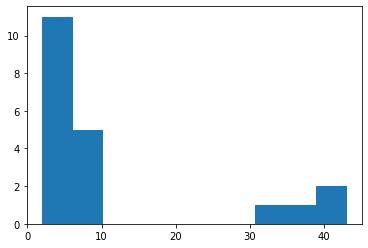

In [60]:
x=[2,5,8,5,7,8,6,42,2,2,4,5,8,9,2,2,37,5,43,32]
plt.hist(x)

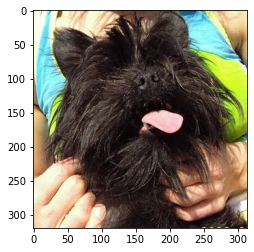

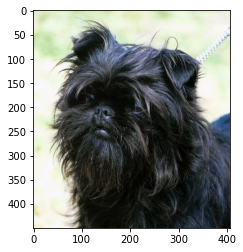

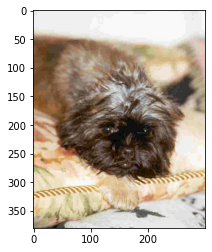

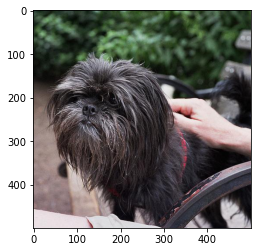

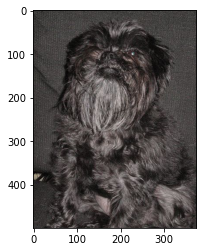

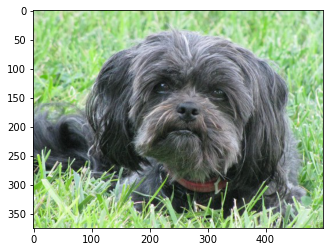

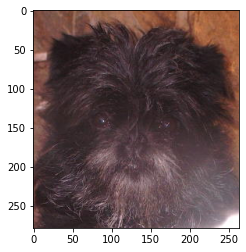

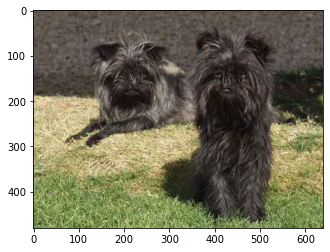

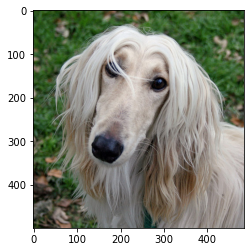

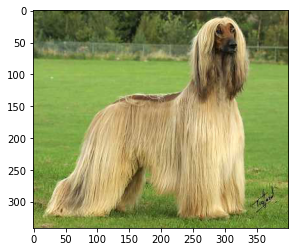

In [57]:
for filename in dog_files[:10]:
    img=Image.open(filename)
    plt.imshow(img)
    plt.show()

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


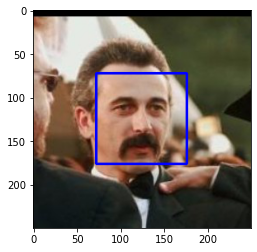

In [2]:

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[10])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [4]:
from tqdm import tqdm
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
# run the function face_detector to check number of True values. 

#define first row
k=0
number_human_face=0
number_dog_face=0
#create loop to run all rows, since human and dog are using 100 images 
for k in tqdm(range(len(human_files_short))):
    if face_detector(human_files_short[k]) == True:
        number_human_face+=1
    if face_detector(dog_files_short[k]) == True:
        number_dog_face+=1
    k+=1    
percent_human=(number_human_face/len(human_files_short))*100
print('human faces ',percent_human, "%")
percent_dog=(number_dog_face/len(dog_files_short))*100
print('dog faces ',percent_dog, "%")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.54it/s]

human faces  96.0 %
dog faces  18.0 %


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [5]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

# extract pre-trained face detector
face_cascade2 = cv2.CascadeClassifier('lbpcascades/lbpcascade_frontalface.xml')

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector2(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces2 = face_cascade2.detectMultiScale(gray)
    return len(faces2) > 0

In [7]:
#define first row
k=0
number_human_face=0
number_dog_face=0
#create loop to run all rows, since human and dog are using 100 images 
for k in tqdm(range(len(human_files_short))):
    if face_detector2(human_files_short[k]):
        number_human_face+=1
    if face_detector2(dog_files_short[k]):
        number_dog_face+=1
    k+=1    
percent_human=(number_human_face/len(human_files_short))*100
print('human faces ',percent_human, "%")
percent_dog=(number_dog_face/len(dog_files_short))*100
print('dog faces ',percent_dog, "%")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.56it/s]

human faces  92.0 %
dog faces  31.0 %


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [8]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [9]:
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [10]:
import io
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np

train_on_gpu = torch.cuda.is_available()
    #Check if available to train on gpu
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
 
    
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path   
    Args:
        img_path: path to an image        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''    
    #open image file 
    input_image = Image.open(img_path)
    #preprocess function defined which transform the image so that images are converted to tensors, 
    #all consistent size and normalised accordingly
    preprocess = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    input_tensor = preprocess(input_image) #create input tensor by feeding input image with the preprocess function.
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    with torch.no_grad(): #no back propogation altering the gradients. Keeping the model attributes the same. 
        output = VGG16(input_batch) #Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    # print(output)
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    # print(torch.nn.functional.softmax(output[0], dim=0))           

    #extract the index with the maximum value in the second dimension which has 0:999 classes of dogs
    xx,predicted = output.max(dim=1)    #xx is the value, predicted is the class index

    #print('Pre-trained model predicts an index of', predicted.item())
    return predicted.item()
    

CUDA is not available.  Training on CPU ...


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    # check prediction of the image
    index_predict=VGG16_predict(img_path)
    
#     #check if output index is between 151 and 268. If yes, True, False for No. 
     
    if index_predict >151 and index_predict<268:
        return True
    else:
        return False

In [12]:
#just to test it out
dog_detector(human_files[0])


False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

detect a dog in human_files 0.0 %, detect a dog in dog_files 94.0 %

In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
nbr_human=0
nbr_dog=0
i=0
for i in tqdm(range(len(human_files_short))):
    if dog_detector(human_files_short[i]):
        nbr_human+=1
    if dog_detector(dog_files_short[i]):
        nbr_dog+=1
    i+=1
     
percent_human=(nbr_human/len(human_files_short))*100
print('detect a dog in human_files',percent_human, "%")
percent_dog=(nbr_dog/len(dog_files_short))*100
print('detect a dog in dog_files',percent_dog, "%")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]

detect a dog in human_files 0.0 %
detect a dog in dog_files 95.0 %


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [14]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### test the Inceptionv3 model

import torch
import torchvision.models as models

# define inception_v3 model
inceptionv3 = models.inception_v3(pretrained=True)
inceptionv3.eval()
# check if CUDA is available
#use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
#if use_cuda:
#    inceptionv3 = inceptionv3.cuda()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [15]:
train_on_gpu = torch.cuda.is_available()
    #Check if available to train on gpu
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
 
    
def inceptionv3_predict(img_path):
  
    #open image file 
    input_image = Image.open(img_path)
    #preprocess function defined which transform the image so that images are converted to tensors, 
    #all consistent size and normalised accordingly
    preprocess = transforms.Compose([transforms.Resize(299),transforms.CenterCrop(299),transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    with torch.no_grad(): #no back propogation altering the gradients. Keeping the model attributes the same. 
        output = inceptionv3(input_batch)        

    #extract the index with the maximum value in the second dimension which has 0:999 classes of dogs
    xx,predicted = output.max(dim=1)

    return predicted.item()
    

CUDA is not available.  Training on CPU ...


In [16]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector2(img_path):
    ## TODO: Complete the function.
    # check prediction of the image
    index_predict=inceptionv3_predict(img_path)
    
#     #check if output index is between 151 and 268. If yes, True, False for No. 
     
    if index_predict >151 and index_predict<268:
        return True
    else:
        return False

In [17]:
x=Image.open(dog_files_short[50])
preprocess = transforms.Compose([transforms.Resize(299),transforms.CenterCrop(299),transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
input_tensor=preprocess(x)
input_batch = input_tensor.unsqueeze(0)
with torch.no_grad(): #no back propogation altering the gradients. Keeping the model attributes the same. 
    output = inceptionv3(input_batch) 

In [18]:
output

tensor([[ 1.3360e+00,  2.0092e-01, -9.5480e-02,  4.3526e-01,  2.6379e-01,
          6.2995e-01, -2.5067e-01, -7.4211e-02, -8.0464e-01, -1.5328e-02,
         -8.0506e-01, -5.8696e-01, -2.3704e-01, -1.6575e-01,  3.0165e-01,
         -9.9964e-01, -5.2787e-01, -5.8024e-01,  2.8647e-01, -4.4553e-01,
         -3.5758e-01, -1.0594e+00,  1.1429e-02, -3.7623e-01, -1.2269e-01,
         -5.7160e-01,  5.8903e-02, -5.9574e-01,  5.5015e-03,  1.5897e-01,
         -3.8086e-01, -3.6539e-01, -1.8732e-01, -2.5193e-02, -1.0256e+00,
         -5.3878e-01,  5.3465e-05,  3.6106e-01,  4.2448e-02, -1.2286e-01,
          1.5350e-01,  3.6934e-02,  6.9781e-01,  1.0114e-01, -3.4729e-02,
         -5.1190e-01,  8.6679e-01, -3.7194e-01,  2.1786e-01, -3.6786e-02,
         -6.2676e-01, -3.2465e-01,  2.7662e-02, -6.1748e-02, -4.1432e-01,
          1.5728e-01, -2.7896e-01,  2.2275e-01,  3.4888e-01, -6.1028e-01,
          2.7571e-01, -6.0972e-01, -3.9783e-01, -3.6988e-01, -7.0124e-01,
         -3.5595e-01, -3.7616e-01,  2.

In [19]:
dog_detector2(human_files_short[50])

False

In [20]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
nbr_human=0
nbr_dog=0
i=0
for i in tqdm(range(len(human_files_short))):
    if dog_detector2(human_files_short[i]):
        nbr_human+=1
    if dog_detector2(dog_files_short[i]):
        nbr_dog+=1
    i+=1
     
percent_human=(nbr_human/len(human_files_short))*100
print('detect a dog in human_files',percent_human, "%")
percent_dog=(nbr_dog/len(dog_files_short))*100
print('detect a dog in dog_files',percent_dog, "%")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]

detect a dog in human_files 0.0 %
detect a dog in dog_files 96.0 %


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [146]:
import os
from random import shuffle
from __future__ import print_function, division
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms, utils

### TODO: Write data loaders for training, validation, and test sets
# define training, test and validation data directories, if on udacity: use /data/....
train_dir = 'dogImages/train'
valid_dir = 'dogImages/valid'
test_dir = 'dogImages/test'

standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
#define transform criterias
train_transforms = transforms.Compose([transforms.Resize(size=256),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       standard_normalization])
validTest_transforms = transforms.Compose([transforms.Resize(size=256),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           standard_normalization])

#create the transformed images into tensors datasets
datatrain = datasets.ImageFolder(train_dir, train_transforms)
datavalid = datasets.ImageFolder(valid_dir, validTest_transforms)
datatest = datasets.ImageFolder(test_dir, validTest_transforms)

#prepare data loaders for each dataset which will be used to feed into the model for batch training, test and validation.
#training loader
train_loader = torch.utils.data.DataLoader(datatrain,batch_size=32,shuffle=True,num_workers=0)
#test loader
valid_loader = torch.utils.data.DataLoader(datavalid,batch_size=32,shuffle=True,num_workers=0)
# test loader
test_loader = torch.utils.data.DataLoader(datatest,batch_size=32,shuffle=True,num_workers=0)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:The images are resized to 256 pixels and centre cropped 224 pixels. If I crop before resize, I might not caputre all the key feature, thus it is crucial to resize and crop after. 

Looking from the sample images on dogimages. The photo of the dogs have their heads being captured in the image and sometimes their body or head is nor orientated right up thus I used a randomrotation. Sometimes the body and head is oiriented from left to right instead of right to left, thus a horizontal random flip is used. 

Image augmentation will create randomness to the dataset created, prevents overfitting, thus giving better overall performance for prediction. Since validation and test data will be used for validation and test check, no randomhorizontal flip or rotation was used.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [568]:
#examples, need to deep dive in detals all each parameter mean and the arguments
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):      #initialise class Net and nn.Module as super initialise the parent class too
        super(Net, self).__init__()
        #define neural network parameters for layers
        # 1 input image with 3 input channel, 16 output channels, 3x3 square convolution
        ## convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # 1 layer of padding with 3 by 3 filter to retain information in the image. 
        self.conv2 = nn.Conv2d(16, 32, 3,padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)          # max pooling layer
        self.fc1 = nn.Linear(64* 28* 28, 1024) #to test
        # dropout layer (p=0.25) #doest matter where its placed as initializing all the different layers, sequence are all done on the forward function
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(1024,133)        
# to define each layer how they interact with each other, input x produce output x for each input/output layers defined.
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) #max pooling with a filter of 2 by 2. 
        x=self.dropout(x)
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x=self.dropout(x)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x=self.dropout(x)
#       print(x.shape) to check the shape
        x=x.view(-1,64*28*28)     #-1 suggests "any size". So it could be 1, 12, 92, 15295...etc
        x=self.dropout(x)
        x = F.relu(self.fc1(x))
        x=self.dropout(x)            # feed through dropout layer. 
        x = self.fc2(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#
model_scratch = Net()   # instantiate the CNN
if use_cuda:  # move tensors to GPU if CUDA is available
    model_scratch.cuda()    
print(model_scratch)    

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1024, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=1024, out_features=133, bias=True)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ Output classification would be 133 different breed of dogs thus 133 for final linear neural network output. Input channels is 3 as for every image there is R,B,G images fed at a time unless its greyscale images. Thus nn.Conv2d(3,6,3) for singe input 6 outputs and filter/kernel of 3*3. The smaller filter size of 3* at the first layer would be useful to extract all the features present in the picture. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [552]:
import torch.optim as optim
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()
# optimizer optimizes the weights to improve and reduce the loss, ca try optim.Adam, best to use decaying learning rate
### TODO: select optimizer #using torch optimizer of SGD (stoichastic gradient descent) for the model's parameters with a learning rate of 0.01. 
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [67]:
from tqdm import tqdm
              
# the following import is required for training to be robust to truncated images called transfer learning.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders1, loaders2, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    old_valid_loss = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train
        
         # Iterate over data.
#         for inputs, labels in dataloaders[phase]:
        for batch_idx, (data, target) in tqdm(enumerate(loaders1)):
        #data,target in iter(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
        
            ## find the loss and update the model parameters accordingly
            #difference between output and target is the loss
            # zero the parameter gradients after each batch data
            optimizer.zero_grad()
            
# forward
            #predicted outputs
            outputs = model(data)
          #  _, preds = torch.max(outputs, 1)
            #batch loss is calculated using criterion
            loss = criterion(outputs, target)

# backward + optimize only in training phase
            #back propogate the loss
            loss.backward()
            # adjust the weights
            optimizer.step()
            
            #what does this mean?
            #train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            ## update the total of train loss after each batch
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        #data is input, output is prediction, 
        for batch_idx, (data, target) in tqdm(enumerate(loaders2)):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
           # forward pass: compute predicted outputs by passing input data to the model
            outputs = model(data)
            
            #batch loss is calculated using criterion
            loss = criterion(outputs, target)
            
             ## update the total of validation loss after each batch
            valid_loss += loss.item()*data.size(0)
            
        #calculate the average train_loss and valid_loss
        train_loss=train_loss/len(train_loader)
        valid_loss=valid_loss/len(valid_loader)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        #new valid loss if its less than the old valid loss, save the model and display the changes from old to new.
        if valid_loss<old_valid_loss:
            #save model with valid loss
            torch.save(model.state_dict(),save_path)
            
            print('Validation loss has decreased ({:.6f} ======> {:.6f}). Saving model ....'.format
                  (old_valid_loss,valid_loss))
            #the retained valid loss will be the new value. 
            old_valid_loss=valid_loss
              
    # return trained model
    return model

In [38]:
# train the model
#def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
model_scratch = train(15, train_loader, valid_loader, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

209it [15:02,  4.32s/it]
27it [00:47,  1.77s/it]


Epoch: 1 	Training Loss: 154.748494 	Validation Loss: 147.151347


0it [00:00, ?it/s]

Validation loss has decreased (inf ======> 147.151347). Saving model ....


209it [13:57,  4.01s/it]
27it [00:51,  1.91s/it]


Epoch: 2 	Training Loss: 143.298646 	Validation Loss: 136.166682


0it [00:00, ?it/s]

Validation loss has decreased (147.151347 ======> 136.166682). Saving model ....


209it [15:43,  4.51s/it]
27it [00:50,  1.88s/it]


Epoch: 3 	Training Loss: 133.906706 	Validation Loss: 132.833833


0it [00:00, ?it/s]

Validation loss has decreased (136.166682 ======> 132.833833). Saving model ....


209it [14:43,  4.23s/it]
27it [00:41,  1.53s/it]


Epoch: 4 	Training Loss: 126.433655 	Validation Loss: 130.028560


0it [00:00, ?it/s]

Validation loss has decreased (132.833833 ======> 130.028560). Saving model ....


209it [13:28,  3.87s/it]
27it [00:39,  1.48s/it]


Epoch: 5 	Training Loss: 118.431558 	Validation Loss: 127.314877


0it [00:00, ?it/s]

Validation loss has decreased (130.028560 ======> 127.314877). Saving model ....


209it [13:16,  3.81s/it]
27it [00:37,  1.37s/it]
0it [00:00, ?it/s]

Epoch: 6 	Training Loss: 109.958539 	Validation Loss: 127.788357


209it [13:15,  3.81s/it]
27it [00:37,  1.40s/it]
0it [00:00, ?it/s]

Epoch: 7 	Training Loss: 102.122388 	Validation Loss: 128.070654


209it [13:16,  3.81s/it]
27it [00:35,  1.32s/it]
0it [00:00, ?it/s]

Epoch: 8 	Training Loss: 93.185619 	Validation Loss: 129.426906


209it [13:09,  3.78s/it]
27it [00:35,  1.33s/it]
0it [00:00, ?it/s]

Epoch: 9 	Training Loss: 84.409638 	Validation Loss: 136.259970


209it [13:13,  3.80s/it]
27it [00:36,  1.36s/it]
0it [00:00, ?it/s]

Epoch: 10 	Training Loss: 74.891031 	Validation Loss: 138.016844


209it [13:25,  3.85s/it]
27it [00:40,  1.51s/it]
0it [00:00, ?it/s]

Epoch: 11 	Training Loss: 66.067524 	Validation Loss: 140.502511


209it [13:32,  3.89s/it]
27it [00:37,  1.40s/it]
0it [00:00, ?it/s]

Epoch: 12 	Training Loss: 56.886658 	Validation Loss: 146.013614


209it [13:24,  3.85s/it]
27it [00:37,  1.40s/it]
0it [00:00, ?it/s]

Epoch: 13 	Training Loss: 49.226632 	Validation Loss: 153.676562


209it [13:13,  3.80s/it]
27it [00:36,  1.34s/it]
0it [00:00, ?it/s]

Epoch: 14 	Training Loss: 42.255484 	Validation Loss: 161.438720


209it [12:51,  3.69s/it]
27it [00:36,  1.34s/it]

Epoch: 15 	Training Loss: 35.736142 	Validation Loss: 167.210647


In [68]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [40]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(test_loader, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.121782


Test Accuracy:  9% (76/836)


<a id='step4'></a>
## Step 3b: Create a better model architect 

Accuracy level less than 10%, observed overfitting occured as training loss reduce but validation loss increase. Create a better model architect which is more simplified with less layers, less cycles, 

In [570]:
class Net2(nn.Module):

    def __init__(self):
        #initialise class Net and nn.Module as super initialise the parent class too
        super(Net2, self).__init__()
        #define neural network parameters for layers
        # 1 input image with 3 channel, 16 output channels, 3x3 square convolution
        # kernel
        ## convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # 1 layer of padding with 3 by 3 filter to retain information in the image. 
        self.pool = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(16, 32, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
    
        self.dropout = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(32, 64, 3,padding=1)
        # max pooling layer
        
        self.pool = nn.MaxPool2d(2, 2)
        # an affine operation: y = Wx + b
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64* 28* 28, 1024) #to test
        
#        self.fc1 = nn.Linear(128* 28* 28, 500)  # 6*6 from image dimension
        # dropout layer (p=0.25) #doest matter where its placed as initializing all the different layers, sequence are all done on the forward function

        self.fc2 = nn.Linear(1024,133)

        
# to define each layer how they interact with each other, input x produce output x for each input/output layers defined.
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) #max pooling with a filter of 2 by 2. 
        x=self.dropout(x)
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x=self.dropout(x)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x=self.dropout(x)
        # flatten
 #       x=x.flatten(1)
#        print(x.shape)
        #-1 suggests "any size". So it could be 1, 12, 92, 15295...etc
        x=x.view(-1,64*28*28)
        # feed through dropout layer. 
        x=self.dropout(x)
#        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x=self.dropout(x)
        x = self.fc2(x)
        return x

    
    
#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch2 = Net2()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch2.cuda()
    
print(model_scratch2)    

Net2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=133, bias=True)
)


In [571]:
# train the model2
#def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
model_scratch2 = train(20, train_loader, valid_loader, model_scratch2, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch2.pt')

0it [00:02, ?it/s]


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 205520896 bytes. Buy new RAM!
(no backtrace available)

In [ ]:
# call test function    
test(test_loader, model_scratch2, criterion_scratch, use_cuda)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [92]:
## TODO: Specify data loaders
train_loader = torch.utils.data.DataLoader(datatrain,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=0)
#test loader
valid_loader = torch.utils.data.DataLoader(datavalid,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=0)
# test loader
test_loader = torch.utils.data.DataLoader(datatest,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=0)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [93]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
#import the VGG16 model
model_transfer=models.vgg16(pretrained=True)


In [94]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [95]:
from collections import OrderedDict

# replace the fully connected layer classifier to match the number of dog classifications required. 
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 133)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# ensures we don’t update the weights from the pre-trained model.
for param in model_transfer.parameters():
    param.requires_grad = False

# Unfreeze training for fully connected (fc) layers   
# for param in model_transfer.fc.parameters():
#     param.requires_grad = True

#map new classifier to the model
model_transfer.classifier=classifier

if use_cuda:
    model_transfer = model_transfer.cuda()

In [96]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
1. utilised the same data loaders as before.
2. created a new object defined as the transfer model. The transfer model is using the VGG16 model. 
3. The classifier of the model is altered to match the intended dog breed output we require. 
4. The weights of this pretrained model is not altered in the convolution network. 
5. Define the classifier of the model to be the classifier we created. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [97]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.0001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [99]:
# train the model
#def train(n_epochs, loaders1, loaders2, model, optimizer, criterion, use_cuda, save_path)
# train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
model_transfer =  train(10,train_loader ,valid_loader ,
                        model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


209it [41:01, 11.78s/it]
27it [05:47, 12.86s/it]


Epoch: 1 	Training Loss: 57.611971 	Validation Loss: 29.459490


0it [00:00, ?it/s]

Validation loss has decreased (inf ======> 29.459490). Saving model ....


209it [53:34, 15.38s/it]
27it [05:50, 12.97s/it]


Epoch: 2 	Training Loss: 13.819745 	Validation Loss: 26.922888


0it [00:00, ?it/s]

Validation loss has decreased (29.459490 ======> 26.922888). Saving model ....


209it [53:31, 15.36s/it]
27it [05:48, 12.91s/it]


Epoch: 3 	Training Loss: 7.364786 	Validation Loss: 23.654617


0it [00:00, ?it/s]

Validation loss has decreased (26.922888 ======> 23.654617). Saving model ....


209it [1:10:45, 20.31s/it]
27it [07:58, 17.71s/it]
0it [00:00, ?it/s]

Epoch: 4 	Training Loss: 6.006021 	Validation Loss: 26.807202


209it [3:58:54, 68.59s/it]  
27it [04:02,  8.97s/it]
0it [00:00, ?it/s]

Epoch: 5 	Training Loss: 3.992521 	Validation Loss: 26.117661


209it [54:34, 15.67s/it]
27it [07:27, 16.59s/it]
0it [00:00, ?it/s]

Epoch: 6 	Training Loss: 3.073030 	Validation Loss: 26.324544


209it [49:34, 14.23s/it]
27it [05:08, 11.41s/it]
0it [00:00, ?it/s]

Epoch: 7 	Training Loss: 2.629387 	Validation Loss: 27.880491


209it [48:49, 14.02s/it]
27it [05:50, 13.00s/it]
0it [00:00, ?it/s]

Epoch: 8 	Training Loss: 2.436524 	Validation Loss: 27.569114


209it [48:51, 14.03s/it]
27it [06:05, 13.54s/it]
0it [00:00, ?it/s]

Epoch: 9 	Training Loss: 2.216582 	Validation Loss: 28.211719


209it [52:14, 15.00s/it]
27it [06:16, 13.96s/it]

Epoch: 10 	Training Loss: 1.794468 	Validation Loss: 28.246503


In [48]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [128]:
test(test_loader, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.971181


Test Accuracy: 78% (659/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [469]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
import glob
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in datatrain.classes]
#raw_class= [item[4:].replace("_", " ") for item in datatrain.classes]
def predict_breed_transfer(img_path):
    
    
    #open image file 
    input_image = Image.open(img_path)
    #preprocess function defined which transform the image so that images are converted to tensors, 
    #all consistent size and normalised accordingly
    preprocess = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    with torch.no_grad(): #no back propogation altering the gradients. Keeping the model attributes the same. 
        output = model_transfer(input_batch)  
        
    #The max value in all outcome probability for all output channels is the predicted class. 
    #extract the index with the maximum value in the second dimension which has 0:999 classes of dogs
    xx,predict = output.max(dim=1)
    
    return datatrain.classes[predict]


In [533]:
#if dog or human detected
def display_image(img_path):
    my_list=[]
    #predictedimage=datatrain.classes(raw_class)
    raw_class=predict_breed_transfer(img_path)
    pred_dir=train_dir+"/"+raw_class+"/*.*"

    class_names =raw_class.replace("_"," ")[4:]

    #prepare random sample data from the predicted breed
    predpath=glob.glob(pred_dir)
    for file in random.sample(list(predpath),1):
      #  print(file)
        a=Image.open(file)
        my_list.append(a)
        
    #open and display input image
    image = Image.open(img_path) #img_path
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("Input Image")

    # display the random sample image from the predicted breed
    plt.subplot(1,2,2)
    plt.imshow(my_list[0])
    plt.title(label=f"Predicted breed:{class_names}")

    plt.show()

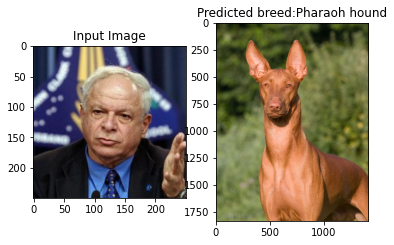

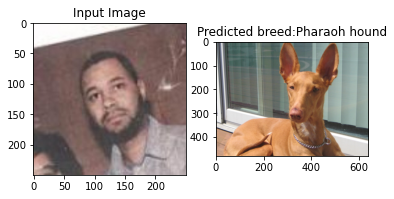

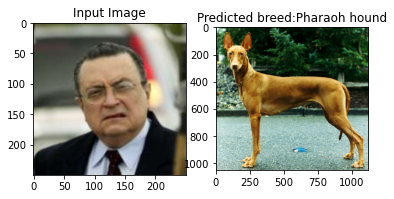

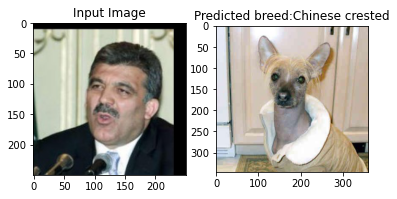

In [534]:

# Try out the function
for image in random.sample(list(human_files_short), 4): 
 #   predicted_breed = predict_breed_transfer(image)
    
    display_image(image)

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [495]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
# if a human face is present, print( "human face present")
    if face_detector(img_path) == True:
        print(" human face present!....This human looks like a ....")
# and then predict what dog breed does the human face looks like
        display_image(img_path)  

# check if a dog is present
# predict dog breed it look like    
    elif dog_detector2(img_path) == True:
        print(" dog is present!...This dog looks like a...")
        display_image(img_path) 
        
 #   we dont find a human or dog in the photo. please try again to reinput the image. No output prediction avaialble.      
    else:
        print("cant find a human or a dog in the photo, please try again")
        image = Image.open(img_path) #img_path
        plt.title("Input Image")
        plt.imshow(image)
        plt.show()

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
1. THe dog breed prediction was only 79% accuracy, still room for improvement in terms of the algorithm with more training, altering the layers, size of the network as well as learning rate and type of criterion and optimizer.
2. Dog breed prediction for human images are not very applicable but there is visible common features. 
3. Cleanup code to make it more modular. 
4. Benchmark different models and parameters used. 
5. Able to handle multiple dog or human in an image. 
6. Return the top 4 classes predicted and their probabilities. 
7. Implement this in an API such as AWS. 


 human face present!....This human looks like a ....


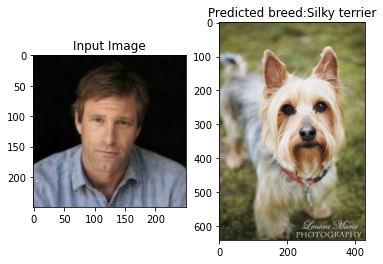

 human face present!....This human looks like a ....


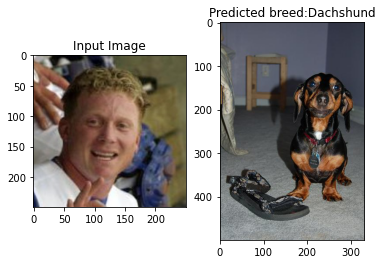

cant find a human or a dog in the photo, please try again


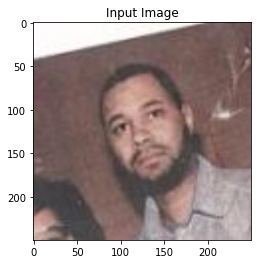

 dog is present!...This dog looks like a...


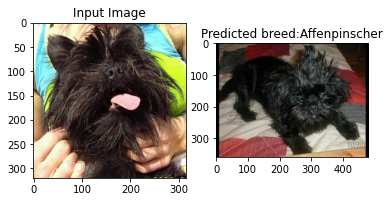

120.Pharaoh_hound
 dog is present!...This dog looks like a...


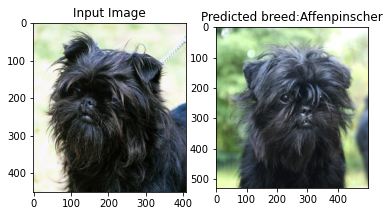

120.Pharaoh_hound
 dog is present!...This dog looks like a...


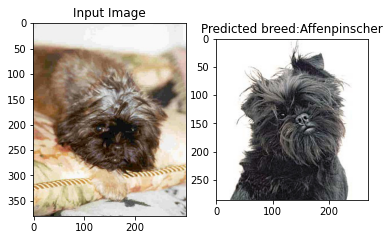

120.Pharaoh_hound


In [535]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

 human face present!....This human looks like a ....


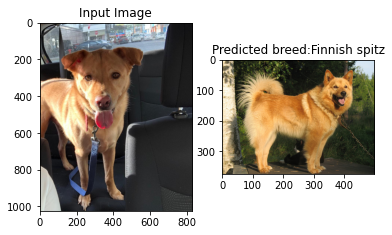


 dog is present!...This dog looks like a...


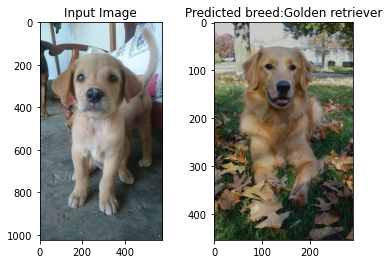

120.Pharaoh_hound

 dog is present!...This dog looks like a...


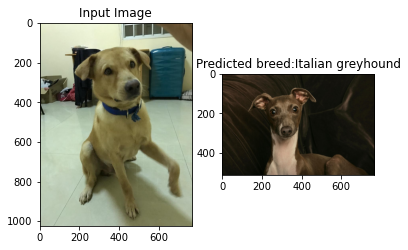

120.Pharaoh_hound

 human face present!....This human looks like a ....


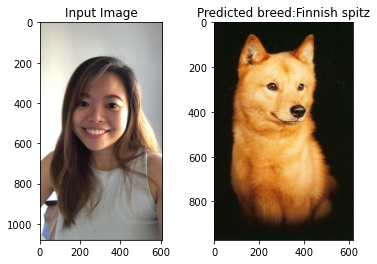


 human face present!....This human looks like a ....


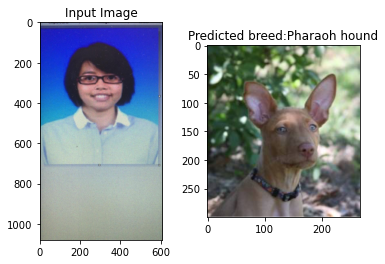

In [548]:
run_app("fahilindog.jpg")
print()
run_app("fahilindog2.jpg")
print()
run_app("fahilindog3.jpg")
print()
run_app("fahilin.jpg")
print()
run_app("fahilin2.jpg")

 dog is present!...This dog looks like a...


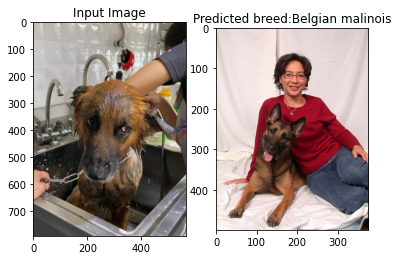

120.Pharaoh_hound

 human face present!....This human looks like a ....


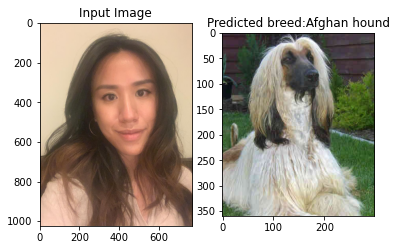


 human face present!....This human looks like a ....


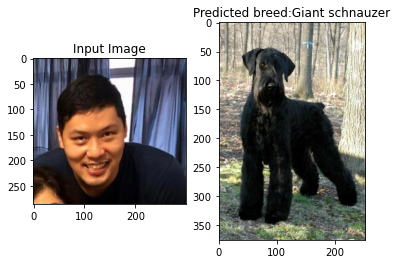


 dog is present!...This dog looks like a...


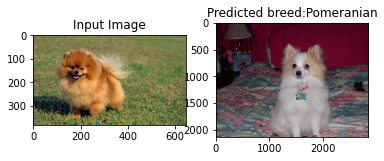

120.Pharaoh_hound

 dog is present!...This dog looks like a...


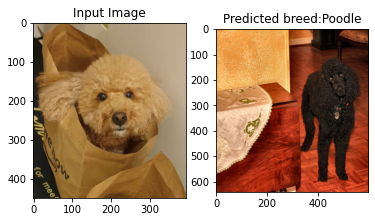

120.Pharaoh_hound

 dog is present!...This dog looks like a...


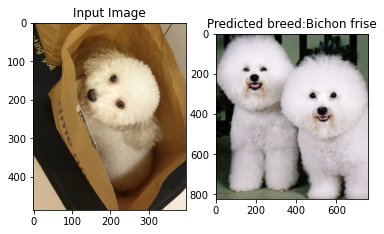

120.Pharaoh_hound


In [545]:
run_app("nicoledog.jpg")
print()
run_app("peiyee3.jpg")
print()
run_app("chung2.jpg")
print()
run_app("pompom.jpg")
print()
run_app("booboo.jpg")
print()
run_app("mina.jpg")